In [2]:
# Read Shape files (.shp) with geopandas
#Get .shp files link for the correspondant area at http://download.geofabrik.de/ and place it in shape_files
import requests
import zipfile
import io
import os
import geopandas as gpd
url = "http://download.geofabrik.de/europe/netherlands/gelderland-latest-free.shp.zip"
extraction = "shape_files"
if not os.path.exists(extraction):
    os.makedirs(extraction)

response = requests.get(url)
if response.status_code == 200:
    zipfile = zipfile.ZipFile(io.BytesIO(response.content))
    zipfile.extractall(extraction)
    print("Shape files downloaded")
    print("Shape files are in shape_files")




Shape files downloaded
Shape files are in shape_files


In [3]:
##Read Files using geopandas
gdf = gpd.read_file("shape_files/gis_osm_buildings_a_free_1.shp") ##Change file name
print(gdf.head())


     osm_id  code    fclass                        name           type  \
0  24913168  1500  building  Ziekenhuis Gelderse Vallei        parking   
1  31858553  1500  building            Omnisportcentrum  sports_centre   
2  38213496  1500  building              Hervormde Kerk         church   
3  38215717  1500  building          Overbetuwe College         school   
4  38215726  1500  building                         NaN         retail   

                                            geometry  
0  POLYGON ((5.64649 52.02248, 5.64730 52.02259, ...  
1  POLYGON ((5.99530 52.21010, 5.99536 52.21015, ...  
2  POLYGON ((5.89660 51.88767, 5.89666 51.88767, ...  
3  POLYGON ((5.91379 51.89246, 5.91402 51.89255, ...  
4  POLYGON ((5.89785 51.89195, 5.89798 51.89203, ...  


In [5]:
'''''''''
Brief Intro: MODIS assumes the Earth is a sphere with a R = 6.3781e6 m (6371007.181 m) radius.
The world is subdivided into 18 vertical tiles and 36 horizontal tiles, each tile has 2400 cells of 500m x 500m.
'''

import math

# Constants
CELLS = 2400
VERTICAL_TILES = 18
HORIZONTAL_TILES = 36
EARTH_RADIUS = 6371007.181
EARTH_WIDTH = 2 * math.pi * EARTH_RADIUS

# Calculate tile and cell sizes
TILE_WIDTH = EARTH_WIDTH / HORIZONTAL_TILES
TILE_HEIGHT = TILE_WIDTH
CELL_SIZE = TILE_WIDTH / CELLS

# Import the Proj class from the pyproj library
from pyproj import Proj

# Define a projection for the MODIS sinusoidal grid
MODIS_GRID = Proj(f'+proj=sinu +R={EARTH_RADIUS} +nadgrids=@null +wktext')

# Function to convert latitude and longitude to MODIS grid coordinates
def lat_lon_to_modis(lat, lon):
    # Use the MODIS_GRID projection to convert latitude and longitude to x, y coordinates
    x, y = MODIS_GRID(lon, lat)
    
    # Calculate horizontal and vertical grid indices (h and v)
    h = (EARTH_WIDTH * 0.5 + x) / TILE_WIDTH
    v = -(EARTH_WIDTH * 0.25 + y - (VERTICAL_TILES - 0) * TILE_HEIGHT) / TILE_HEIGHT
    
    # Return the grid indices as integers
    return int(h), int(v)

# Example usage
x, y = lat_lon_to_modis(52.449265, 5.834519)
print(x)
print(y)


18
3


In [6]:
from pymodis import downmodis
'''''''''
Product must be same name from the list at https://e4ftl01.cr.usgs.gov/MOLT/
'''''
# Define the parameters
product = 'MOD09A1.061'  # e.g., 'MOD09A1'
tiles = 'h18v03'  # e.g., 'h17v03,h18v03' #Gelderland falls in 18th Horizontally and third vertically.
if not os.path.exists('NIR'):
    os.makedirs('NIR')
output_directory = './NIR/' #Output Directory
day = "2023-08-01" #Starting Day
endDate = "2023-08-31" #Ending Day

# Initialize the downloader
modis_downloader = downmodis.downModis(
    product=product,
    tiles=tiles,
    user='',#Change to your username
    password='',#Change to your password
    destinationFolder=output_directory,
    today=day,
    enddate=endDate
)

# Download the data
modis_downloader.connect()
modis_downloader.downloadsAllDay()


In [78]:

import glob

import numpy as np
from collections import OrderedDict
from osgeo import gdal
from pymodis import parsemodis
import datetime
#Get List of Downloaded Files
files = glob.glob(os.path.join(output_directory, 'MOD09A1*.hdf'))
#Initialize Dictionary to Store NDVI Values And List to Store Temporal Values
tempList = []
NDVI_DICT = {}

for file in files:
    #Get Day Value From Filename
    #Given filename for example is MOD09A1.A2023217.h18v03.061.2023226041025.hdf
    #We want to get the day value of the file
    #So we split the filename on the period and then on the underscore
    #Then we take the second item in the list which is the day value
    #We then convert it to an integer
    #We convert it using datetime using year and day
    #Subtract 1 from the day value to get the correct date
    day_value = int(file.split('/')[-1].split('.')[1][5:])
    year = 2023
    date = datetime.datetime(year, 1, 1) + datetime.timedelta(day_value - 1)
    #Read hdf file and get the red and nir values
    hdf = gdal.Open(file, gdal.GA_ReadOnly)
    #Get the dictionary of hdf metadata
    hdfDict = hdf.GetMetadata('SUBDATASETS')
    #Get the list of hdf metadata keys that contain the name of the hdf file
    hdfList =[hdfDict[k] for k in hdfDict.keys() if '_NAME' in k]
    #Open each hdf file and get the red and nir values
    for n in hdfList:
        tempList.append(gdal.Open(n))
    #RED_VALUES is the first band sur_refl_b01 (620-670 nm)
    RED_VALUES = tempList[0].GetRasterBand(1).ReadAsArray().astype(np.int16)
    #NIR_VALUES is the second band sur_refl_b02 (841-876 nm)
    NIR_VALUES = tempList[1].GetRasterBand(1).ReadAsArray().astype(np.int16)
    #Calculate NDVI Values
    NDVI_VALUES = (NIR_VALUES - RED_VALUES) / (NIR_VALUES + RED_VALUES)
    #Add NDVI Values to Dictionary
    NDVI_DICT[date] = NDVI_VALUES
    #Clear Temp List
    tempList = []
#Sort Dictionary by Key Date
NDVI_DICT = OrderedDict(sorted(NDVI_DICT.items(), key=lambda x: x[0]))
if not os.path.exists('NDVI_Images'):
    os.makedirs('NDVI_Images')


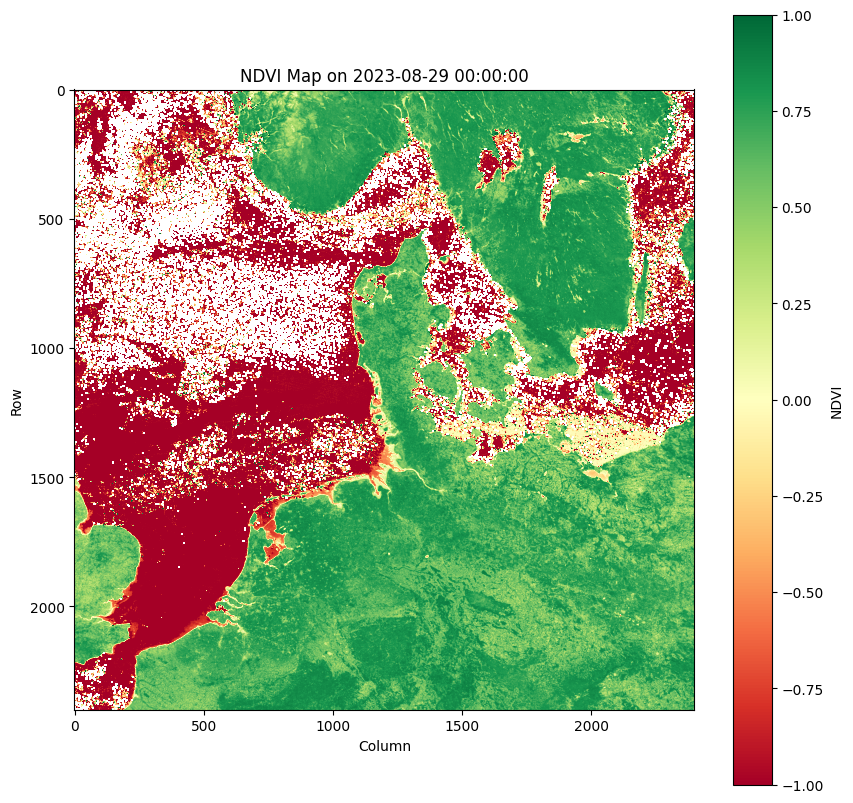

In [87]:
import matplotlib.pyplot as plt
cmap = plt.get_cmap('RdYlGn')
first_item = next(iter(NDVI_DICT.items()))
# Plot the NDVI array
plt.figure(figsize=(10, 10))  # Set the figure size as needed
plt.imshow(first_item[1], cmap=cmap, vmin=-1, vmax=1)  # Set vmin and vmax for the color scale
plt.colorbar(label='NDVI')
plt.title(f'NDVI Map on {first_item[0]}')
plt.xlabel('Column')
plt.ylabel('Row')

# Save the plot as an image (e.g., PNG)
plt.savefig('ndvi_plot.png', dpi=300, bbox_inches='tight')
# Show the plot (you can also save it using plt.savefig)
plt.show()


In [ ]:
def verifyDate(date:str):
    try:
        datetime.datetime.strptime(date, '%Y-%m-%d')
    except ValueError:
        raise ValueError("Incorrect data format, should be YYYY-MM-DD")

def value_aggregate(dateStart: str, dateEnd:str):
    ##verify date format
    verifyDate(dateStart)
    verifyDate(dateEnd)
    modis_downloader = downmodis.downModis(
    product=product,
    tiles=tiles,
    user='',#Change to your username
    password='',#Change to your password
    destinationFolder=output_directory,
    today=dateStart,
    enddate=dateEnd,
    )
    modis_downloader.connect()
    modis_downloader.downloadsAllDay()
    files = glob.glob(os.path.join(output_directory, 'MOD09A1*.hdf'))
    #Initialize Dictionary to Store NDVI Values And List to Store Temporal Values
    tempList = []
    NDVI_DICT = {}

    for file in files:
        #Get Day Value From Filename
        #Given filename for example is MOD09A1.A2023217.h18v03.061.2023226041025.hdf
        #We want to get the day value of the file
        #So we split the filename on the period and then on the underscore
        #Then we take the second item in the list which is the day value
        #We then convert it to an integer
        #We convert it using datetime using year and day
        #Subtract 1 from the day value to get the correct date
        day_value = int(file.split('/')[-1].split('.')[1][5:])
        year = 2023
        date = datetime.datetime(year, 1, 1) + datetime.timedelta(day_value - 1)
        #Read hdf file and get the red and nir values
        hdf = gdal.Open(file, gdal.GA_ReadOnly)
        #Get the dictionary of hdf metadata
        hdfDict = hdf.GetMetadata('SUBDATASETS')
        #Get the list of hdf metadata keys that contain the name of the hdf file
        hdfList =[hdfDict[k] for k in hdfDict.keys() if '_NAME' in k]
        #Open each hdf file and get the red and nir values
        for n in hdfList:
            tempList.append(gdal.Open(n))
        #RED_VALUES is the first band sur_refl_b01 (620-670 nm)
        RED_VALUES = tempList[0].GetRasterBand(1).ReadAsArray().astype(np.int16)
        #NIR_VALUES is the second band sur_refl_b02 (841-876 nm)
        NIR_VALUES = tempList[1].GetRasterBand(1).ReadAsArray().astype(np.int16)
        #Calculate NDVI Values
        NDVI_VALUES = (NIR_VALUES - RED_VALUES) / (NIR_VALUES + RED_VALUES)
        #Add NDVI Values to Dictionary
        NDVI_DICT[date] = NDVI_VALUES
        cmap = plt.get_cmap('RdYlGn')
         # Get the first item from the dictionary
        # Plot the NDVI array
        plt.figure(figsize=(10, 10))  # Set the figure size as needed
        plt.imshow(NDVI_VALUES, cmap=cmap, vmin=-1, vmax=1)  # Set vmin and vmax for the color scale
        plt.colorbar(label='NDVI')
        plt.title(f'NDVI Map on {date}')
        plt.xlabel('Column')
        plt.ylabel('Row')

        # Save the plot as an image (e.g., PNG)
        plt.savefig(f'./NDVI_Images/{date}_ndvi.png', dpi=300, bbox_inches='tight')
        #Clear Temp List
        tempList = []
    #Sort Dictionary by Key Date
    NDVI_DICT = OrderedDict(sorted(NDVI_DICT.items(), key=lambda x: x[0]))
    

